# LAB 4b:  Create Keras DNN model.

**Learning Objectives**

1. Set CSV Columns, label column, and column defaults
1. Make dataset of features and label from CSV files
1. Create input layers for raw features
1. Create DNN dense hidden layers and output layer
1. Create custom evaluation metric
1. Build DNN model tying all of the pieces together
1. Train and evaluate


## Introduction 
In this notebook, we'll be using Keras to create a DNN model to predict the weight of a baby before it is born.

We'll start by defining the CSV column names, label column, and column defaults for our data inputs. Then, we'll construct a `tf.data Dataset` of features and the label from the CSV files and create inputs layers for the raw features. Next, we'll set up preprocessing layers for the model inputs and build a deep neural network in Keras. We'll create a custom evaluation metric and build our DNN model. Finally, we'll train and evaluate our model.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/4b_keras_dnn_babyweight.ipynb).

## Load necessary libraries

In [1]:
import datetime
import os
import shutil

import keras
import matplotlib.pyplot as plt
import tensorflow as tf

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

2026-01-09 02:59:27.941142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767927567.976936   64505 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767927567.985237   64505 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-09 02:59:28.016511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Verify CSV files exist

In the seventh lab of this series [4a_sample_babyweight](../solutions/4a_sample_babyweight.ipynb), we sampled from BigQuery our train, eval, and test CSV files. Verify that they exist, otherwise go back to that lab and create them.

In [2]:
%%bash
ls *.csv

eval.csv
test.csv
train.csv


In [3]:
%%bash
head -5 *.csv

==> eval.csv <==
8.62448368944,True,31,Single(1),42
5.62619692624,True,22,Single(1),40
8.421658408399999,Unknown,33,Single(1),39
2.8373493119399997,Unknown,25,Single(1),29
1.6556715876199999,Unknown,30,Single(1),23

==> test.csv <==
6.9996768185,True,26,Single(1),37
6.3603362587,Unknown,31,Single(1),39
6.1244416383599996,Unknown,22,Single(1),38
8.56936812394,Unknown,25,Single(1),41
6.6248909731,Unknown,28,Single(1),38

==> train.csv <==
5.32857287254,False,26,Single(1),37
7.5839018128,False,24,Single(1),40
7.50012615324,Unknown,28,Single(1),40
9.2483918909,True,25,Single(1),41
8.50102482272,True,40,Single(1),37


## Create Keras model

### Set CSV Columns, label column, and column defaults.

Now that we have verified that our CSV files exist, we need to set a few things that we will be using in our input function.
* `CSV_COLUMNS` are going to be our header names of our columns. Make sure that they are in the same order as in the CSV files
* `LABEL_COLUMN` is the header name of the column that is our label. We will need to know this to pop it from our features dictionary.
* `DEFAULTS` is a list with the same length as `CSV_COLUMNS`, i.e. there is a default for each column in our CSVs. Each element is a list itself with the default value for that CSV column.

In [4]:
# Determine CSV, label, and key columns
# Create list of string column headers, make sure order matches.
CSV_COLUMNS = [
    "weight_pounds",
    "is_male",
    "mother_age",
    "plurality",
    "gestation_weeks",
]

# Add string name for label column
LABEL_COLUMN = "weight_pounds"

NUMERICAL_COLUMNS = ["mother_age", "gestation_weeks"]
CATEGORICAL_COLUMNS = ["is_male", "plurality"]

# Set default values for each CSV column as a list of lists.
# Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0]]

### Make dataset of features and label from CSV files.

Next, we will write an input_fn to read the data. This will create a CSV dataset object. However we will need to divide the columns up into features and a label. We can do this by applying the map method to our dataset and popping our label column off of our dictionary of feature tensors.

In [5]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.

    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL_COLUMN)

    return row_data, label


def decode_csv(line):
    fields = tf.io.decode_csv(line, record_defaults=DEFAULTS)
    return dict(zip(CSV_COLUMNS, fields))


def load_dataset(pattern, batch_size=1, mode="eval"):
    """Loads dataset using the tf.data API from CSV files.

    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: called when training or evaluating
    Returns:
        `Dataset` object.
    """
    dataset = tf.data.Dataset.list_files(pattern, shuffle=(mode == "train"))

    # Use TextLineDataset to read the content of these files
    # interleave allows reading from multiple files in parallel
    dataset = dataset.interleave(
        tf.data.TextLineDataset, num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.map(decode_csv, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(
        map_func=features_and_labels, num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size)
    # Shuffle for training
    if mode == "train":
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.repeat().prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

### Create input layers for raw features.

We'll need to get the data read in by our input function to our model function, but just how do we go about connecting the dots? We can use Keras input layers by defining:
* shape: A shape tuple (integers), not including the batch size. For instance, shape=(32,) indicates that the expected input will be batches of 32-dimensional vectors. Elements of this tuple can be None; 'None' elements represent dimensions where the shape is not known.
* name: An optional name string for the layer. Should be unique in a model (do not reuse the same name twice). It will be autogenerated if it isn't provided.
* dtype: The data type expected by the input, as a string (float32, float64, int32...)

In [6]:
def create_input_layers():
    """Creates dictionary of input layers for each feature.

    Returns:
        Dictionary of `keras.Input` layers for each feature.
    """
    inputs = {
        colname: keras.Input(name=colname, shape=(1,), dtype="float32")
        for colname in NUMERICAL_COLUMNS
    }

    inputs.update(
        {
            colname: keras.Input(name=colname, shape=(1,), dtype="string")
            for colname in CATEGORICAL_COLUMNS
        }
    )

    return inputs

### Define preprocessing layers for inputs.

Next, define the preprocessing layers to the transform raw features. `mother_age` and `gestation_weeks` should be numeric. The others, `is_male` and `plurality`, should be categorical. 

In [7]:
def transform(inputs):
    """Creates dictionary of transformed inputs.

    Returns:
        Dictionary of transformed Tensors
    """

    transformed = {}

    for numerical_column in NUMERICAL_COLUMNS:
        transformed[numerical_column] = inputs[numerical_column]

    vocab = {
        "is_male": ["True", "False", "Unknown"],
        "plurality": [
            "Single(1)",
            "Twins(2)",
            "Triplets(3)",
            "Quadruplets(4)",
            "Quintuplets(5)",
            "Multiple(2+)",
        ],
    }

    for categorical_column in CATEGORICAL_COLUMNS:
        transformed[categorical_column] = keras.layers.StringLookup(
            vocabulary=vocab[categorical_column], output_mode="one_hot"
        )(inputs[categorical_column])

    return transformed

### Create DNN dense hidden layers and output layer.

So we've figured out how to get our inputs ready for machine learning but now we need to connect them to our desired output. Our model architecture is what links the two together. Let's create some hidden dense layers beginning with our inputs and end with a dense output layer. This is regression so make sure the output layer activation is correct and that the shape is right.

In [8]:
def get_model_outputs(inputs):
    """Creates model architecture and returns outputs.

    Args:
        inputs: Dense tensor used as inputs to model.
    Returns:
        Dense tensor output from the model.
    """
    # Create two hidden layers of [64, 32]
    h1 = keras.layers.Dense(64, activation="relu", name="h1")(inputs)
    h2 = keras.layers.Dense(32, activation="relu", name="h2")(h1)

    # Final output is a linear activation because this is regression
    output = keras.layers.Dense(units=1, activation="linear", name="weight")(h2)

    return output

### Build DNN model tying all of the pieces together.

Excellent! We've assembled all of the pieces, now we just need to tie them all together into a Keras Model. This is a simple feedforward model with no branching, side inputs, etc. so we could have used Keras' Sequential Model API but just for fun we're going to use Keras' Functional Model API. Here we will build the model using `keras.models.Model` giving our inputs and outputs and then compile our model with an optimizer, a loss function, and evaluation metrics.

In [9]:
def build_dnn_model():
    """Builds simple DNN using Keras Functional API.

    Returns:
        `keras.models.Model` object.
    """
    # Create input layer
    inputs = create_input_layers()

    # transform
    transformed = transform(inputs)

    # The Functional API in Keras requires: LayerConstructor()(inputs)
    dnn_inputs = keras.layers.Concatenate()(list(transformed.values()))

    # Get output of model given inputs
    output = get_model_outputs(dnn_inputs)

    # Build model and compile it all together
    model = keras.models.Model(inputs=inputs, outputs=output)
    rmse = keras.metrics.RootMeanSquaredError(
        name="root_mean_squared_error", dtype=None
    )
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

    return model


print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:



2026-01-09 02:59:31.367762: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ is_male             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plurality           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mother_age          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gestation_weeks     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup       │ (None, 4)         │          0 │ is_male[0][0]     │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_1     │ (None, 7)         │          0 │ plurality[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 13)        │          0 │ mother_age[0][0], │
│ (Concatenate)       │                   │            │ gestation_weeks[… │
│                     │                   │            │ string_lookup[0]… │
│                     │                   │            │ string_lookup_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h1 (Dense)          │ (None, 64)        │        896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h2 (Dense)          │ (None, 32)        │      2,080 │ h1[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weight (Dense)      │ (None, 1)         │         33 │ h2[0][0]          │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

None


We can visualize the DNN using the Keras plot_model utility.

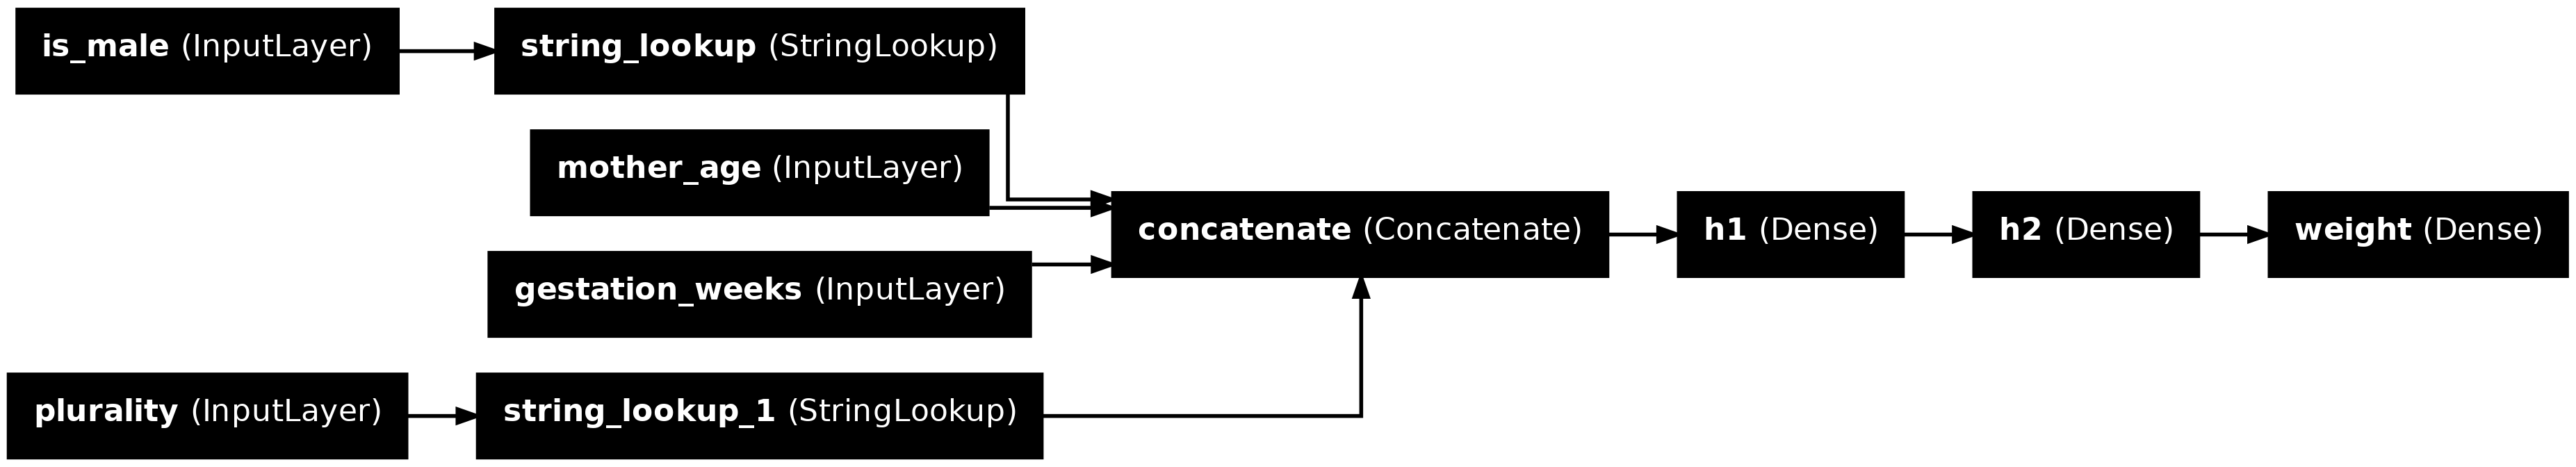

In [20]:
keras.utils.plot_model(model=model, show_layer_names=True, rankdir="LR")

## Run and evaluate model

### Train and evaluate.

We've built our Keras model using our inputs from our CSV files and the architecture we designed. Let's now run our model by training our model parameters and periodically running an evaluation to track how well we are doing on outside data as training goes on. We'll need to load both our train and eval datasets and send those to our model through the fit method. Make sure you have the right pattern, batch size, and mode when loading the data. Also, don't forget to add the callback to TensorBoard.

In [11]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset repeats, it'll wrap around
NUM_EVALS = 5  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 10000

trainds = load_dataset(
    pattern="train*",
    batch_size=TRAIN_BATCH_SIZE,
    mode="train",
)

evalds = load_dataset(pattern="eval*", batch_size=1000, mode="eval").take(
    count=NUM_EVAL_EXAMPLES // 1000
)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1
)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback],
)

Epoch 1/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.1259 - mse: 2.1259 - root_mean_squared_error: 1.4580 - val_loss: 1.2025 - val_mse: 1.2025 - val_root_mean_squared_error: 1.0966
Epoch 2/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1860 - mse: 1.1860 - root_mean_squared_error: 1.0891 - val_loss: 1.1569 - val_mse: 1.1569 - val_root_mean_squared_error: 1.0756
Epoch 3/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1451 - mse: 1.1451 - root_mean_squared_error: 1.0701 - val_loss: 1.1304 - val_mse: 1.1304 - val_root_mean_squared_error: 1.0632
Epoch 4/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1880 - mse: 1.1880 - root_mean_squared_error: 1.0899 - val_loss: 1.2044 - val_mse: 1.2044 - val_root_mean_squared_error: 1.0975
Epoch 5/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1591 - mse: 1.1591 - root_mean_squared_error: 1.0766 - val_loss: 1.1820 - val_mse: 1.1820 - val_root_mean_squared_error: 1.0872


### Visualize loss curve

In [12]:
history.history

{'loss': [2.125871181488037,
  1.186046838760376,
  1.145110845565796,
  1.187972068786621,
  1.159109354019165],
 'mse': [2.125871181488037,
  1.186046838760376,
  1.145110845565796,
  1.187972068786621,
  1.159109354019165],
 'root_mean_squared_error': [1.4580367803573608,
  1.0890578031539917,
  1.0700985193252563,
  1.0899412631988525,
  1.0766193866729736],
 'val_loss': [1.2024800777435303,
  1.1568971872329712,
  1.1303848028182983,
  1.204404354095459,
  1.1819970607757568],
 'val_mse': [1.2024800777435303,
  1.1568971872329712,
  1.1303848028182983,
  1.204404354095459,
  1.1819970607757568],
 'val_root_mean_squared_error': [1.0965765714645386,
  1.0755915641784668,
  1.0631955862045288,
  1.0974535942077637,
  1.0871968269348145]}

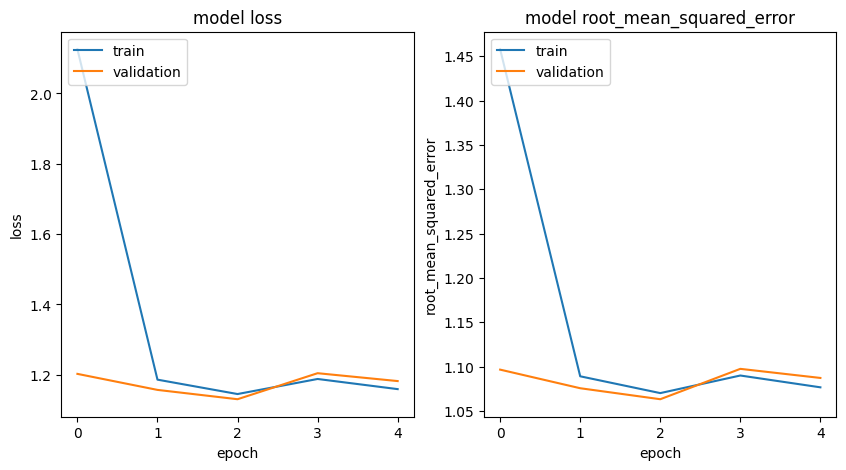

In [14]:
# Plot
import matplotlib.pyplot as plt

nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(["loss", "root_mean_squared_error"]):
    ax = fig.add_subplot(nrows, ncols, idx + 1)
    plt.plot(history.history[key])
    plt.plot(history.history[f"val_{key}"])
    plt.title(f"model {key}")
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left");

### Save the model

In [33]:
OUTPUT_DIR = "babyweight_trained"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(OUTPUT_DIR, TIMESTAMP)

SAVEDMODEL_PATH = os.path.join(EXPORT_PATH, "savedmodel")
KERAS_PATH = os.path.join(EXPORT_PATH, "model.keras")

model.export(EXPORT_PATH)
model.save(KERAS_PATH)

INFO:tensorflow:Assets written to: babyweight_trained/20260109043022/assets


INFO:tensorflow:Assets written to: babyweight_trained/20260109043022/assets


Saved artifact at 'babyweight_trained/20260109043022'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Dict[['mother_age', TensorSpec(shape=(None, 1), dtype=tf.float32, name='mother_age')], ['gestation_weeks', TensorSpec(shape=(None, 1), dtype=tf.float32, name='gestation_weeks')], ['is_male', TensorSpec(shape=(None, 1), dtype=tf.string, name='is_male')], ['plurality', TensorSpec(shape=(None, 1), dtype=tf.string, name='plurality')]]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139806348079376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806348079024: TensorSpec(shape=(), dtype=tf.int64, name=None)
  139806348081136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806348081312: TensorSpec(shape=(), dtype=tf.int64, name=None)
  139806348076736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806348379760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806348383456: TensorSpec

In [34]:
!ls $EXPORT_PATH

assets	fingerprint.pb	model.keras  saved_model.pb  variables


## Lab Summary: 
In this lab, we started by defining the CSV column names, label column, and column defaults for our data inputs. Then, we constructed a tf.data Dataset of features and the label from the CSV files and created inputs layers for the raw features. Next, we set up preprocessing layers for the model inputs and built a deep neural network in Keras. We created a custom evaluation metric and built our DNN model. Finally, we trained and evaluated our model.

Copyright 2026 Google LLC
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.